# COMS 6998 - Practical Deep Learning System Performance

## Assignment 4
* **Name**: Zach Lawless
* **UNI**: ztl2103

### Problem 1: *Transfer Learning: Shallow Learning vs Fine Tuning, PyTorch* (30 points)

#### Q1

Using [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) as reference.

* a: (4 points)

Using the `vgg-flowers` Visual Domain Decathalon dataset.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '~/data/vgg-flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

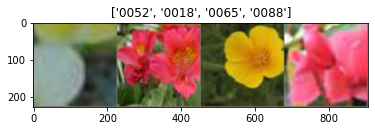

In [3]:
# Funtion to plot image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [4]:
# Show how many classes there are in the training dataset
print(f"There are {len(class_names)} target classes in the training dataset")

There are 102 target classes in the training dataset


In [5]:
# Show the distribution of training images per class
base_dir = '/home/jupyter/data/vgg-flowers/train/'

print("Distribution of training images per class")
for cn in os.listdir(base_dir):
    cn_images = os.listdir(os.path.join(base_dir, cn))
    print(f'Class {cn}: {len(cn_images)} images')

Distribution of training images per class
Class 0028: 10 images
Class 0075: 10 images
Class 0029: 10 images
Class 0009: 10 images
Class 0092: 10 images
Class 0085: 10 images
Class 0061: 10 images
Class 0056: 10 images
Class 0074: 10 images
Class 0050: 10 images
Class 0013: 10 images
Class 0069: 10 images
Class 0040: 10 images
Class 0072: 10 images
Class 0003: 10 images
Class 0017: 10 images
Class 0101: 10 images
Class 0094: 10 images
Class 0026: 10 images
Class 0046: 10 images
Class 0008: 10 images
Class 0071: 10 images
Class 0049: 10 images
Class 0080: 10 images
Class 0067: 10 images
Class 0044: 10 images
Class 0100: 10 images
Class 0102: 10 images
Class 0007: 10 images
Class 0089: 10 images
Class 0015: 10 images
Class 0087: 10 images
Class 0004: 10 images
Class 0077: 10 images
Class 0022: 10 images
Class 0030: 10 images
Class 0090: 10 images
Class 0060: 10 images
Class 0005: 10 images
Class 0025: 10 images
Class 0036: 10 images
Class 0064: 10 images
Class 0053: 10 images
Class 0099: 

In [6]:
# Load pretrained Resnet50 and change final layer
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

* b: (8 points)

In [7]:
# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Set up criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 60 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

# Send model to device
model_ft = model_ft.to(device)

In [9]:
# Train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 4.6525 Acc: 0.0225
val Loss: 4.5929 Acc: 0.0196

Epoch 1/199
----------
train Loss: 4.5687 Acc: 0.0265
val Loss: 4.4863 Acc: 0.0578

Epoch 2/199
----------
train Loss: 4.4612 Acc: 0.0882
val Loss: 4.3703 Acc: 0.1412

Epoch 3/199
----------
train Loss: 4.3490 Acc: 0.1373
val Loss: 4.2245 Acc: 0.2235

Epoch 4/199
----------
train Loss: 4.2027 Acc: 0.2225
val Loss: 4.0441 Acc: 0.2716

Epoch 5/199
----------
train Loss: 4.0379 Acc: 0.2804
val Loss: 3.8313 Acc: 0.2902

Epoch 6/199
----------
train Loss: 3.8418 Acc: 0.3157
val Loss: 3.6239 Acc: 0.3412

Epoch 7/199
----------
train Loss: 3.6518 Acc: 0.3657
val Loss: 3.4105 Acc: 0.3824

Epoch 8/199
----------
train Loss: 3.4888 Acc: 0.4137
val Loss: 3.2118 Acc: 0.3961

Epoch 9/199
----------
train Loss: 3.2932 Acc: 0.4333
val Loss: 3.0344 Acc: 0.4353

Epoch 10/199
----------
train Loss: 3.0963 Acc: 0.4500
val Loss: 2.8744 Acc: 0.4637

Epoch 11/199
----------
train Loss: 2.9870 Acc: 0.4765
val Loss: 2.7030 Acc

* c: (6 points)

Repeating the exercise above except with uniform learning rate equal to 0.1 and 0.01 and no learning rate decay.

In [10]:
LR_SET = [0.1, 0.01]

for lr in LR_SET:
    print(f'----- Performing experiment with fixed lr={lr} -----\n')
    
    # Load pretrained Resnet50 and change final layer
    model_ft = models.resnet50(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))

    # Set up criterion
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 1000 epochs (never going to step, setting artifically high for fixing lr)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1000, gamma=0.1)

    # Send model to device
    model_ft = model_ft.to(device)
    
    # Train model
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

----- Performing experiment with fixed lr=0.1 -----

Epoch 0/199
----------
train Loss: 5.2498 Acc: 0.0196
val Loss: 749843.8510 Acc: 0.0098

Epoch 1/199
----------
train Loss: 5.0352 Acc: 0.0206
val Loss: 795.6690 Acc: 0.0108

Epoch 2/199
----------
train Loss: 4.4090 Acc: 0.0363
val Loss: 10.2650 Acc: 0.0373

Epoch 3/199
----------
train Loss: 4.0696 Acc: 0.0422
val Loss: 5.0215 Acc: 0.0500

Epoch 4/199
----------
train Loss: 3.8868 Acc: 0.0559
val Loss: 3.8237 Acc: 0.0824

Epoch 5/199
----------
train Loss: 3.6877 Acc: 0.0882
val Loss: 4.1769 Acc: 0.1176

Epoch 6/199
----------
train Loss: 3.5217 Acc: 0.1245
val Loss: 3.7040 Acc: 0.1314

Epoch 7/199
----------
train Loss: 3.3368 Acc: 0.1480
val Loss: 3.5623 Acc: 0.1686

Epoch 8/199
----------
train Loss: 3.2987 Acc: 0.1647
val Loss: 3.5789 Acc: 0.1647

Epoch 9/199
----------
train Loss: 3.2518 Acc: 0.1667
val Loss: 3.5565 Acc: 0.1735

Epoch 10/199
----------
train Loss: 3.0891 Acc: 0.1941
val Loss: 3.9557 Acc: 0.1451

Epoch 11/199
-

The results for the three learning rate approaches are below in the table.

| Learning Rate Setting | Best Validation Accuracy |
| ----------------------|--------------------------|
| 0.01 with decay       | 0.803                    |
| 0.1 fixed             | 0.520                    |
| 0.01 fixed            | 0.813                    |

The fixed learning rate of 0.01 for all 200 epochs gave the best validation accuracy for the three experiments.

#### Q2

* a: (8 points)

Treating `ResNet50` as a feature extractor and only training the final layer with various learning rates.

In [11]:
LR_SET = [10**i for i in range(-3, 1)]

for lr in LR_SET:
    print(f'\n----- Performing experiment with fixed lr={lr} -----\n')
    
    model_conv = torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, len(class_names))

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 60 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=60, gamma=0.1)
    
    # Train model
    model_conv = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=200)


----- Performing experiment with fixed lr=0.001 -----

Epoch 0/199
----------
train Loss: 4.6785 Acc: 0.0147
val Loss: 4.6396 Acc: 0.0127

Epoch 1/199
----------
train Loss: 4.6253 Acc: 0.0127
val Loss: 4.5816 Acc: 0.0255

Epoch 2/199
----------
train Loss: 4.5631 Acc: 0.0284
val Loss: 4.5245 Acc: 0.0441

Epoch 3/199
----------
train Loss: 4.5190 Acc: 0.0412
val Loss: 4.4712 Acc: 0.0745

Epoch 4/199
----------
train Loss: 4.4662 Acc: 0.0755
val Loss: 4.4178 Acc: 0.1069

Epoch 5/199
----------
train Loss: 4.4225 Acc: 0.0912
val Loss: 4.3649 Acc: 0.1441

Epoch 6/199
----------
train Loss: 4.3570 Acc: 0.1490
val Loss: 4.3146 Acc: 0.1755

Epoch 7/199
----------
train Loss: 4.3206 Acc: 0.1961
val Loss: 4.2642 Acc: 0.2059

Epoch 8/199
----------
train Loss: 4.2621 Acc: 0.2343
val Loss: 4.2143 Acc: 0.2461

Epoch 9/199
----------
train Loss: 4.2095 Acc: 0.2392
val Loss: 4.1662 Acc: 0.2735

Epoch 10/199
----------
train Loss: 4.1708 Acc: 0.2853
val Loss: 4.1173 Acc: 0.3029

Epoch 11/199
------

The best validation accuracy when using `ResNet50` as a feature extractor on `vgg-flowers` for the various learning rates are below.

| Learning Rate Setting | Best Validation Accuracy |
| ----------------------|--------------------------|
| 0.001                 | 0.615                    |
| 0.01                  | 0.624                    |
| 0.1                   | 0.632                    |
| 1                     | 0.622                    |

From above, we can see that 0.1 is the best learning rate for using `ResNet50` as a feature extractor for the `vgg-flowers` VDD dataset.

* b: (4 points)

Given the two transfer learning approaches (Fine Tuning and Feature Extraction) and the various learning rate schemes, using Fine Tuning with a fixed learning rate equal to 0.01 resulted in the best validation accuracy on the holdout dataset. This isn't surprising, as the `ResNet50` model was pretrained on `ImageNet`, not the `vgg-flowers` dataset. Allowing for weight updates on the layers prior to the final Dense layers allows for `ResNet50` to learn features and representations specific to the `vgg-flowers` dataset.

### Problem 2: *Weakly and Semi-Supervised Learning for Image Classification* (20 points)

#### Q1 (2 points)

The difference between weakly and semi-supervised pretraining is related to the labeling mechanism. Weakly supervised learning uses tags or labels, which can often be noisy, innacurate, and imbalanced, to train models on. The noise and imbalance in the tags can reduce performance of models. Semi-supervised learning takes advantage of a teacher-student architecture to select the Top-K images per class with the teacher model and train the student model on the subsampled dataset.

#### Q2

* a: (2 points) 

The model trained using hashtags is robust against noise in the labels. To test this, Mahajan et al randomly injected, 10%, 25%, and 50% label noise into the targets, and observed that there was only a 1 and 2 percent degredation in performance when injection 10 and 25 percent label noise, respectively. This showed that label noise is a miniscule issue to models trained on billions of images. 

* b: (2 points)

Hashtags exhibit a Zipfian distribution, and it has been shown that resampling Zipfian distributions reduces the impact of the head of the word distribution when pretraining for transfer learning.

#### Q3

* a: (4 points)

There are two models, the teacher and the student, for the purposes of selecting the best data to train on per class (teacher) and training on the best data (student). The student model leverages the teacher in the sense that the output of the teacher model is a subsample of images the teacher has the most confidence in per class, and this is the data the student is trained on. This can be thought of as a distillation technique because the more inaccurate or noisy images that the teacher has less confidence in are not fed to the student for learning; only the most "pure" training images are left after the teacher distillation process.

* b: (4 points)

K and P are hyperparameters for selecting which data to feed from the teacher to the student. K represents the Top-K images per class labelled by the teacher on the unlabelled dataset that will be fed to the student, and P represents the Top-P softmax probabilities per image that are kept for ranking the Top-K images per class. We use P > 1 to account for uncertainty in selecting only the most likely label assigned from the teacher, as well as to capture some of the less represented or infrequent labels that were learned by the teacher. A higher value for P leads to a more robust dataset to select the Top-K images per class from for the student.

* c: (4 points)

A new labelled dataset is created from the unlabbeled data by using the teacher to generate the Top-P softmax probabilities per image. From here, we rank and select the Top-K images per class from the Top-P softmax probabilities per image. It is possible for an image in the unlabelled dataset to belong to multiple classes with this approach, and Yalzin et al simply allow for an image with multiple Top-K class labels to be replicated in the dataset that is fed to the student.

* d: (2 points)

The accuracy of the student model demonstrates an inverted parabola shape with increasing K hyperparameter value because at a certain point, the original noise from the weakly labelled dataset is reintroduced with larger K values selected by the teacher model.

### Problem 3: *PALEO, FLOPs, Platform Percent of Peak (PPP)* (20 points)

#### Q1 (4 points)

Achieving peak FLOPs from GPU hardware is a difficult proposition in real systems because you typically need to develop customized libraries that take advantage of intimate knowledge of the underlying GPU hardware, which most people outside of the developers of the GPU hardware possess. Platform Percent of Peak (PPP) helps capture this inefficiency by taking the average relative inefficiency of the platform compared to peak FLOPS.

#### Q2 (6 points)

The difference between VGG16 and VGG19 is the additional convolutional layer in the third and fourth convolution block of VGG19.

The two additional convolution layers are 3x3x512 layers, where the input size to the first is 28x28x512 and the input size to the second is 14x14x512.

From this, we can calculate the additional number of multiplications as follows:

$$ 2 x (3 x 3 x 512) x 512 = 4718592 $$

Adding this number to the number of FLOPs from Table 3 in Lu et al results in roughly 15365M FLOPs for the CONVs in VGG19.

Adding the above to the unchanged number of FLOPs for POOL, ReLU, and FC layers in VGG19 results in a total of 15508M FLOPs for VGG19.

#### Q3 (4 points)

The measured time and sum of layerwise timings for forward pass did not match on GPUs for AlexNet, VGG16, GoogleNet, and ResNet50 due to communication and measurement overhead differences between TK1 and TX1. The authors keep GPUs iteratively running the matrix multiplication in a way that GPU cores can continuously perform multiply-add operations without synchronization, before recording the end time. After this, the measurement overhead is amortized over all the iterations, giving accurate timing estimates. When the number of iterations is large enough, the overhead is negligible.

#### Q4 (6 points)

The peak double-precision floating point performance of a NVIDIA Tesla K80 is 1.87 TFLOPS.

The FLOPs for VGG16, GoogleNet, and ResNet50 are in the table below.

| Model Architecture | FLOPS |
| -------------------|-------|
| VGG16              | 15503M|
| GoogleNet          | 1606M |
| ResNet50           | 3922M |

The computation time formula is calculated as the FLOP counts of the operation divided by the FLOPS of the device.

Using this formula, the computation time for the three models above is:

| Model Architecture | FLOPS | K80 TFLOPS | Computation Time |
| -------------------|-------|------------|------------------|
| VGG16              | 15503M| 1.87       | 8 ms             |
| GoogleNet          | 1606M | 1.87       | 0.8 ms           |
| ResNet50           | 3922M | 1.87       | 2 ms             |

Given these computation times, we can divide by 1 second to get throughput, or the number of images processed per second.

| Model Architecture | FLOPS | K80 TFLOPS | Computation Time | Throughput |
| -------------------|-------|------------|------------------|------------|
| VGG16              | 15503M| 1.87       | 8 ms             | 125        |
| GoogleNet          | 1606M | 1.87       | 0.8 ms           | 1250       |
| ResNet50           | 3922M | 1.87       | 2 ms             | 500        |


### Problem 4: *Optimus, Learning and Resource Models, Performance-Cost Tradeoffs* (30 points)

#### Q1: (15 points)

I worked on this question with Shawn Pachgade, Roberto Ponce, Nick Christman, and Wang Yao.

I used [this code repository](https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py) for building out my `ResNet20` implementation.

So far, I've testing on the following GPUs (this is for my own record keeping):

- [X] K80
- [X] P100
- [X] V100

Import the necessary packages and set up the ResNet20 module.

In [2]:
import copy

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms

import pandas as pd

import time

In [2]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

Create a function to train the model

In [3]:
def train_model(model, resnet_layers, hardware, dataloaders, criterion, optimizer, scheduler, num_epochs=350):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    metrics = []
    training_step = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_phase_start_time = time.time()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                step_start_time = time.time()
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        metrics.append({
                            'resnet_layers': resnet_layers,
                            'hardware': hardware,
                            'epoch': epoch,
                            'training_step': training_step,
                            'training_step_loss': loss.item(),
                            'training_step_time': time.time() - step_start_time
                        })
                        
                        training_step += 1

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_phase_end_time = time.time()
            
            print(f'{phase} Loss: {round(epoch_loss, 4)} Acc: {round(epoch_acc.item(), 4)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_model_wts = copy.deepcopy(model.state_dict())
                       
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {round(best_acc, 4)}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # set up return structure
    return_df = pd.DataFrame(data=metrics)
    
    return model, return_df

Load CIFAR-10 data.

In [4]:
BATCHSIZE = 128
DATA_DIR = '~/data/cifar10'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}


train_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,
                                        download=True, transform=data_transforms['train'])

val_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False,
                                       download=True, transform=data_transforms['val'])

image_datasets = {'train': train_set, 'val': val_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Extracting /home/jupyter/data/cifar10/cifar-10-python.tar.gz to /home/jupyter/data/cifar10
Files already downloaded and verified
Dataset sizes: {'train': 50000, 'val': 10000}
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Set up learning criteria and train.

In [5]:
# Fetch model
model = resnet20()

# Set up criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 60 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Send model to device
model = model.to(device)

# Train
num_epochs = 350
resnet_layers = 20
hardware = 'K80'
model, results_df = train_model(model, resnet_layers, hardware, dataloaders,
                                criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/349
----------

train Loss: 1.473 Acc: 0.4655
val Loss: 1.2322 Acc: 0.562

Epoch 1/349
----------
train Loss: 0.9335 Acc: 0.6677
val Loss: 0.9706 Acc: 0.6647

Epoch 2/349
----------
train Loss: 0.7192 Acc: 0.7495
val Loss: 0.7323 Acc: 0.7429

Epoch 3/349
----------
train Loss: 0.6051 Acc: 0.789
val Loss: 0.6667 Acc: 0.7655

Epoch 4/349
----------
train Loss: 0.5261 Acc: 0.8163
val Loss: 0.7175 Acc: 0.7629

Epoch 5/349
----------
train Loss: 0.4531 Acc: 0.8407
val Loss: 0.6559 Acc: 0.7821

Epoch 6/349
----------
train Loss: 0.396 Acc: 0.8598
val Loss: 0.6327 Acc: 0.7971

Epoch 7/349
----------
train Loss: 0.347 Acc: 0.8766
val Loss: 0.6986 Acc: 0.7891

Epoch 8/349
----------
train Loss: 0.311 Acc: 0.8891
val Loss: 0.7333 Acc: 0.7777

Epoch 9/349
----------
train Loss: 0.2625 Acc: 0.9075
val Loss: 0.6963 Acc: 0.7885

Epoch 10/349
----------
train Loss: 0.2284 Acc: 0.9186
val Loss: 0.7719 Acc: 0.7766

Epoch 11/349
----------
train Loss: 0.2075 Acc: 0.9257
val Loss: 0.7753 Acc: 0.7

In [6]:
results_df.shape

(136850, 6)

In [7]:
results_df.head(20)

,resnet_layers,hardware,epoch,training_step,training_step_loss,training_step_time
0,20,K80,0,0,3.425021,2.043396
1,20,K80,0,1,2.860192,0.096694
2,20,K80,0,2,3.165385,0.091998
3,20,K80,0,3,3.740157,0.087504
4,20,K80,0,4,3.208768,0.085457
5,20,K80,0,5,3.059932,0.080485
6,20,K80,0,6,3.161976,0.078340
7,20,K80,0,7,2.510218,0.076159
8,20,K80,0,8,2.822329,0.075174
9,20,K80,0,9,2.698619,0.073195


In [8]:
results_df.to_csv(f'q4_data/layers_{resnet_layers}_{hardware}.csv', index=False)

Now that me and my teammates have trained all of the various `ResNet` models on `K80`, `P100`, and `V100`, load in all of the training data and fit each model.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
def f(k, b0, b1, b2):
    l = (1 / (b0 * k + b1)) + b2
    return l

In [3]:
resnets = [18, 20, 32, 44, 56]
gpus = ['K80', 'P100', 'V100']

models = {}

for r in resnets:
    for g in gpus:
        print(f'fitting resnet{r} from gpu {g}')
        df_r_g = pd.read_csv(f'q4_data/resnet{r}_{g}.csv')
        df_r_g = df_r_g.groupby(['resnet_layers', 'hardware', 'epoch'])['training_step_loss'].mean().reset_index()
        df_r_g.rename(columns={'training_step_loss': 'epoch_loss'}, inplace=True)
        
        # fit training loss function and store
        l = df_r_g['epoch_loss'].values
        k = df_r_g['epoch'].values
        betas, _ = curve_fit(f, xdata=k, ydata=l, bounds=(0, np.inf))
        models[(r, g)] = betas

fitting resnet18 from gpu K80
fitting resnet18 from gpu P100
fitting resnet18 from gpu V100
fitting resnet20 from gpu K80
fitting resnet20 from gpu P100
fitting resnet20 from gpu V100
fitting resnet32 from gpu K80
fitting resnet32 from gpu P100
fitting resnet32 from gpu V100
fitting resnet44 from gpu K80
fitting resnet44 from gpu P100
fitting resnet44 from gpu V100
fitting resnet56 from gpu K80
fitting resnet56 from gpu P100
fitting resnet56 from gpu V100


The training loss model parameters learned for the various configurations of `ResNet` layers and GPU are below.

In [4]:
models

{(18, 'K80'): array([2.79606191e-01, 4.38387877e-01, 1.10788921e-15]),
 (18, 'P100'): array([2.89971602e-01, 4.58898067e-01, 8.40719734e-22]),
 (18, 'V100'): array([2.59958482e-01, 4.67686329e-01, 8.29936723e-20]),
 (20, 'K80'): array([4.29991087e-01, 6.58764805e-01, 7.68529319e-22]),
 (20, 'P100'): array([4.22362166e-01, 6.36503622e-01, 5.20377854e-21]),
 (20, 'V100'): array([4.22374333e-01, 6.56266751e-01, 1.12818064e-21]),
 (32, 'K80'): array([3.73487534e-01, 5.30811749e-01, 3.78300354e-18]),
 (32, 'P100'): array([4.00031023e-01, 5.80132607e-01, 5.13036268e-17]),
 (32, 'V100'): array([3.66265454e-01, 5.15098275e-01, 5.44771001e-19]),
 (44, 'K80'): array([2.08930924e-01, 4.00375364e-01, 1.14601918e-19]),
 (44, 'P100'): array([3.51199957e-01, 4.88508870e-01, 9.08728878e-24]),
 (44, 'V100'): array([3.36027035e-01, 4.48961778e-01, 6.14817529e-17]),
 (56, 'K80'): array([3.24700516e-01, 4.64460939e-01, 2.80048358e-21]),
 (56, 'P100'): array([3.02823087e-01, 4.37064899e-01, 1.46106375e-22]

#### Q2: (8 points)

Training `ResNet50` to 92% training accuracy.

So far, I've trained on the following GPUs (this is for my own record keeping):

- [X] K80
- [X] P100
- [X] V100

In [1]:
import copy

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms

import pandas as pd

import time

In [2]:
# load ResNet50
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/jupyter/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [3]:
# set up data preproceesing
BATCHSIZE = 128
DATA_DIR = '~/data/cifar10'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}


train_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,
                                        download=True, transform=data_transforms['train'])

val_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False,
                                       download=True, transform=data_transforms['val'])

image_datasets = {'train': train_set, 'val': val_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCHSIZE,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Extracting /home/jupyter/data/cifar10/cifar-10-python.tar.gz to /home/jupyter/data/cifar10
Files already downloaded and verified
Dataset sizes: {'train': 50000, 'val': 10000}
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# function to perform training with early stopping at 92% accuarcy
def train_model(model, resnet_layers, hardware, dataloaders, criterion, optimizer, scheduler, num_epochs=350, acc_thresh=0.92):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    metrics = []
    training_step = 0
    epoch = 0
    threshold_not_met = True
    
    while epoch < num_epochs and threshold_not_met:
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_phase_start_time = time.time()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                step_start_time = time.time()
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        metrics.append({
                            'resnet_layers': resnet_layers,
                            'hardware': hardware,
                            'epoch': epoch,
                            'training_step': training_step,
                            'training_step_loss': loss.item(),
                            'training_step_time': time.time() - step_start_time
                        })
                        
                        training_step += 1

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_phase_end_time = time.time()
            
            print(f'{phase} Loss: {round(epoch_loss, 4)} Acc: {round(epoch_acc.item(), 4)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_model_wts = copy.deepcopy(model.state_dict())
                 
            if phase == 'train' and epoch_acc >= acc_thresh:
                print("!!! MET ACCURACY THRESHOLD, STOPPING !!!")
                threshold_not_met = False

        epoch += 1
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {round(best_acc, 4)}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # set up return structure
    return_df = pd.DataFrame(data=metrics)
    
    return model, return_df

In [5]:
# Set up criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 60 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Send model to device
model = model.to(device)

# Train
num_epochs = 350
resnet_layers = 50
acc_thresh = 0.92
hardware = 'V100'
model, results_df = train_model(model, resnet_layers, hardware, dataloaders,
                                criterion, optimizer, exp_lr_scheduler, num_epochs, acc_thresh)


Epoch 0/349
----------
train Loss: 2.387 Acc: 0.2429
val Loss: 1.8514 Acc: 0.3165

Epoch 1/349
----------
train Loss: 1.7665 Acc: 0.3467
val Loss: 1.6653 Acc: 0.3798

Epoch 2/349
----------
train Loss: 1.6171 Acc: 0.4065
val Loss: 1.5176 Acc: 0.4398

Epoch 3/349
----------
train Loss: 1.5003 Acc: 0.4518
val Loss: 1.4791 Acc: 0.462

Epoch 4/349
----------
train Loss: 1.4098 Acc: 0.4858
val Loss: 1.4081 Acc: 0.4943

Epoch 5/349
----------
train Loss: 1.3187 Acc: 0.5236
val Loss: 1.3106 Acc: 0.5224

Epoch 6/349
----------
train Loss: 1.2383 Acc: 0.5517
val Loss: 1.2523 Acc: 0.5514

Epoch 7/349
----------
train Loss: 1.1777 Acc: 0.5768
val Loss: 1.2196 Acc: 0.5709

Epoch 8/349
----------
train Loss: 1.0925 Acc: 0.6067
val Loss: 1.1322 Acc: 0.6047

Epoch 9/349
----------
train Loss: 1.0778 Acc: 0.612
val Loss: 1.081 Acc: 0.6114

Epoch 10/349
----------
train Loss: 0.9746 Acc: 0.6513
val Loss: 1.0486 Acc: 0.6281

Epoch 11/349
----------
train Loss: 0.9105 Acc: 0.6744
val Loss: 1.0428 Acc: 0

In [6]:
results_df.shape

(10166, 6)

In [7]:
results_df.head(20)

,resnet_layers,hardware,epoch,training_step,training_step_loss,training_step_time
0,50,V100,0,0,13.322277,6.653620
1,50,V100,0,1,7.019900,0.064077
2,50,V100,0,2,4.346029,0.051719
3,50,V100,0,3,3.709551,0.053324
4,50,V100,0,4,3.560764,0.053852
5,50,V100,0,5,4.032091,0.052706
6,50,V100,0,6,2.668718,0.053849
7,50,V100,0,7,4.557339,0.052973
8,50,V100,0,8,5.248215,0.058157
9,50,V100,0,9,3.843186,0.053047


In [8]:
results_df.to_csv(f'q4_data/resnet{resnet_layers}_{hardware}.csv', index=False)

Now that I have trained `ResNet50` on `K80`, `P100`, and `V100`, load in all of the training data.

In [5]:
resnet50_training_data = []
for g in gpus:
    df_50_g = pd.read_csv(f'q4_data/resnet50_{g}.csv')
    df_50_g = df_50_g.groupby(['resnet_layers', 'hardware', 'epoch'])['training_step_loss'].mean().reset_index()
    df_50_g.rename(columns={'training_step_loss': 'epoch_loss'}, inplace=True)
    resnet50_training_data.append(df_50_g)

df_resnet50_training_data = pd.concat(resnet50_training_data, axis=0, ignore_index=True)
print(df_resnet50_training_data.shape)
df_resnet50_training_data.head()

(77, 4)


,resnet_layers,hardware,epoch,epoch_loss
0,50,K80,0,2.509837
1,50,K80,1,1.711982
2,50,K80,2,1.538258
3,50,K80,3,1.440099
4,50,K80,4,1.354824


Next, fit linear models given the number of `ResNet` layers and type of GPU for $\beta_0$, $\beta_1$, and $\beta_2$.

In [6]:
# format data
beta_data = []
for (r, g), betas in models.items():
    beta_data.append({
        'layers': r,
        'K80': 1 if g == 'K80' else 0,
        'P100': 1 if g == 'P100' else 0,
        'V100': 1 if g == 'V100' else 0,
        'beta0': betas[0],
        'beta1': betas[1],
        'beta2': betas[2]
    })
df_beta = pd.DataFrame(beta_data)
df_beta

,layers,K80,P100,V100,beta0,beta1,beta2
0,18,1,0,0,0.279606,0.438388,1.107889e-15
1,18,0,1,0,0.289972,0.458898,8.407197e-22
2,18,0,0,1,0.259958,0.467686,8.299367e-20
3,20,1,0,0,0.429991,0.658765,7.685293e-22
4,20,0,1,0,0.422362,0.636504,5.203779e-21
5,20,0,0,1,0.422374,0.656267,1.128181e-21
6,32,1,0,0,0.373488,0.530812,3.783004e-18
7,32,0,1,0,0.400031,0.580133,5.130363e-17
8,32,0,0,1,0.366265,0.515098,5.447710e-19
9,44,1,0,0,0.208931,0.400375,1.146019e-19


In [7]:
from sklearn import linear_model

In [8]:
# fit models
beta_models = {}
for i in range(3):
    reg = linear_model.LinearRegression()
    X = df_beta[['layers', 'K80', 'P100', 'V100']].values
    y = df_beta[[f'beta{i}']].values
    reg.fit(X, y)
    beta_models[i] = reg
beta_models

{0: LinearRegression(), 1: LinearRegression(), 2: LinearRegression()}

Now that the regression models have been trained, predict the training loss curve for `ResNet50` on the various GPUs.

In [9]:
df_predict = pd.DataFrame({
    'layers': 50,
    'K80': [1, 0, 0],
    'P100': [0, 1, 0],
    'V100': [0, 0, 1],
})

df_predict

,layers,K80,P100,V100
0,50,1,0,0
1,50,0,1,0
2,50,0,0,1


In [10]:
pred_betas = {}
for i in range(3):
    reg = beta_models[i]
    X = df_predict.values
    y_pred = reg.predict(X)
    pred_betas[f'beta{i}'] = y_pred.reshape(1, -1).tolist()[0]
df_pred_betas = pd.DataFrame(pred_betas)
df_pred_betas

,beta0,beta1,beta2
0,0.298335,0.444646,1.340355e-16
1,0.328269,0.466308,-7.806061e-17
2,0.304232,0.442670,-7.590045e-17


In [11]:
df_predict_w_betas = pd.concat([df_predict, df_pred_betas], axis=1)
df_predict_w_betas

,layers,K80,P100,V100,beta0,beta1,beta2
0,50,1,0,0,0.298335,0.444646,1.340355e-16
1,50,0,1,0,0.328269,0.466308,-7.806061e-17
2,50,0,0,1,0.304232,0.442670,-7.590045e-17


In [12]:
resnet50_pred_training_loss = {}
for idx, g in enumerate(gpus):
    k = np.arange(max(df_r_g['epoch'].values))
    b0 = df_predict_w_betas['beta0'][idx]
    b1 = df_predict_w_betas['beta1'][idx]
    b2 = df_predict_w_betas['beta2'][idx]
    resnet50_pred_training_loss[g] = f(k, b0, b1, b2)

In [13]:
resnet50_pred_training_loss

{'K80': array([2.24897889, 1.34592871, 0.96032276, 0.74646267, 0.6105055 ,
        0.51644302, 0.44749593, 0.39478998, 0.35319121, 0.31952325,
        0.29171547, 0.26836034, 0.24846769, 0.23132066, 0.21638752,
        0.20326551, 0.19164398, 0.18127948, 0.17197853, 0.16358542,
        0.1559734 , 0.1490383 , 0.14269366, 0.13686715, 0.1314978 ,
        0.12653382, 0.12193099, 0.11765127, 0.1136618 , 0.10993401,
        0.10644298, 0.10316685, 0.10008636, 0.0971845 , 0.09444617,
        0.09185793, 0.08940776, 0.0870849 , 0.08487968, 0.08278339,
        0.08078815, 0.07888683, 0.07707294, 0.07534059, 0.0736844 ,
        0.07209946, 0.07058127, 0.0691257 , 0.06772895, 0.06638753,
        0.06509821, 0.06385802, 0.0626642 , 0.0615142 , 0.06040564,
        0.05933633, 0.05830423, 0.05730741, 0.0563441 , 0.05541265,
        0.05451149, 0.05363917, 0.05279433, 0.0519757 , 0.05118206,
        0.05041229, 0.04966534, 0.04894019, 0.04823592, 0.04755163,
        0.04688649, 0.04623969, 0.0456105

Make the dataframe for the plotting the predicted loss curve with the actual loss curve for each `ResNet50` trained on the different GPUs, with percent error.

In [14]:
viz_data = []
perc_error = {}
for g in gpus:
    print(f'{g}')
    
    actual_train_loss = df_resnet50_training_data[df_resnet50_training_data.hardware==g]['epoch_loss'].values
    pred_training_loss_g = resnet50_pred_training_loss[g]
    pred_training_loss_g_sub = pred_training_loss_g[:len(actual_train_loss)]
    perc_diff = pred_training_loss_g_sub - actual_train_loss / actual_train_loss
    
    df_g_actual = pd.DataFrame(data={
        'gpu': g,
        'mode': 'actual',
        'epoch': df_resnet50_training_data[df_resnet50_training_data.hardware==g]['epoch'].values.tolist(),
        'epoch_loss': df_resnet50_training_data[df_resnet50_training_data.hardware==g]['epoch_loss'].values.tolist(),
    })
    df_g_pred = pd.DataFrame(data={
        'gpu': g,
        'mode': 'predict',
        'epoch': np.arange(pred_training_loss_g.shape[0]).tolist(),
        'epoch_loss': pred_training_loss_g.tolist()
    })
    
    viz_data.append(df_g_actual)
    viz_data.append(df_g_pred)
    
    perc_error[g] = perc_diff
    
df_viz = pd.concat(viz_data, axis=0, ignore_index=True)
print(df_viz.shape)
df_viz.head()

K80
P100
V100
(1124, 4)


,gpu,mode,epoch,epoch_loss
0,K80,actual,0,2.509837
1,K80,actual,1,1.711982
2,K80,actual,2,1.538258
3,K80,actual,3,1.440099
4,K80,actual,4,1.354824


In [15]:
perc_error

{'K80': array([ 1.24897889,  0.34592871, -0.03967724, -0.25353733, -0.3894945 ,
        -0.48355698, -0.55250407, -0.60521002, -0.64680879, -0.68047675,
        -0.70828453, -0.73163966, -0.75153231, -0.76867934, -0.78361248,
        -0.79673449, -0.80835602, -0.81872052, -0.82802147, -0.83641458,
        -0.8440266 , -0.8509617 , -0.85730634, -0.86313285, -0.8685022 ,
        -0.87346618, -0.87806901]),
 'P100': array([ 1.14450671,  0.25853098, -0.10940644, -0.31087528, -0.43800827,
        -0.52553907, -0.58947826, -0.6382309 , -0.67663321, -0.707665  ,
        -0.73326238, -0.75473797, -0.77301314, -0.78875371, -0.80245276,
        -0.81448329, -0.82513262, -0.8346257 , -0.84314115, -0.85082259,
        -0.85778682, -0.86412982, -0.86993116, -0.87525737]),
 'V100': array([ 1.25902136,  0.33886442, -0.04864621, -0.26219176, -0.39744436,
        -0.49079091, -0.55909493, -0.61124194, -0.65235844, -0.68560954,
        -0.71305514, -0.7360936 , -0.75570754, -0.7726077 , -0.78732085,
   

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

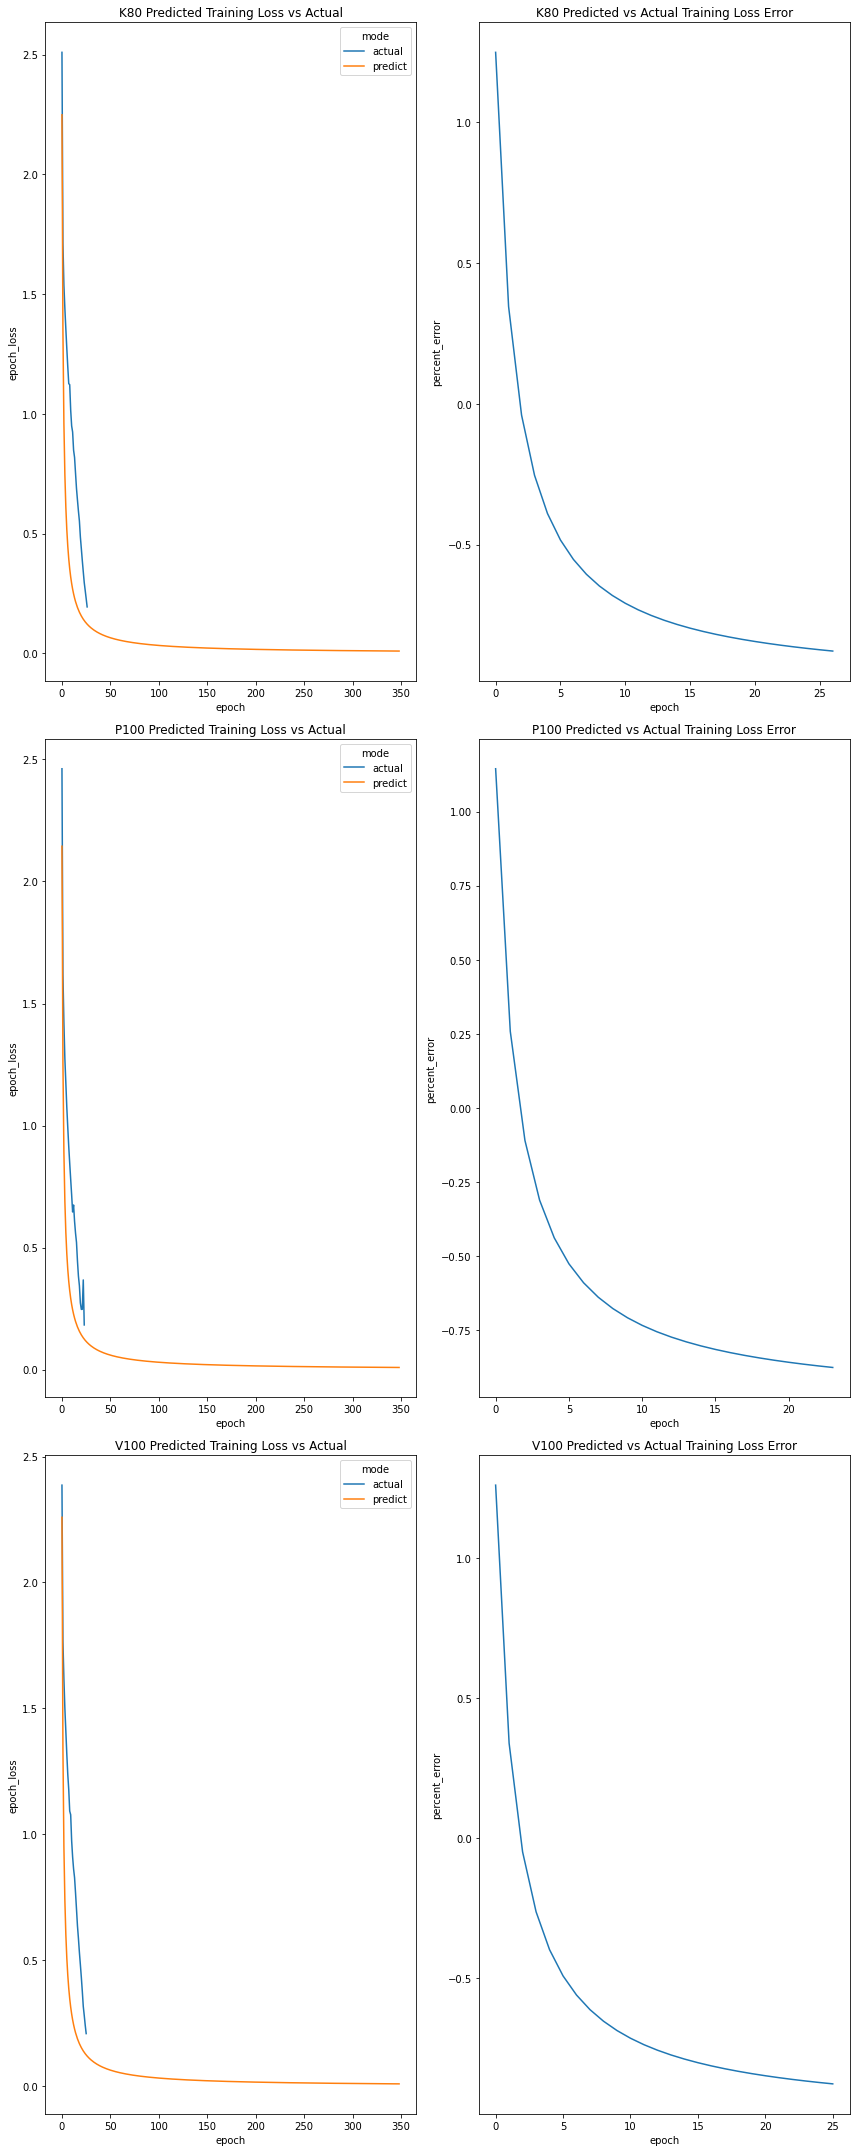

In [18]:
fig, axs = plt.subplots(nrows=len(gpus), ncols=2, figsize=(12, 30))
for idx, g in enumerate(gpus):
    df_for_plot = df_viz[df_viz.gpu == g]
    df_g_error = pd.DataFrame(data={
        'epoch': np.arange(len(perc_error[g])),
        'percent_error': perc_error[g]
    })
    sns.lineplot(x='epoch', y='epoch_loss', hue='mode', data=df_for_plot, ax=axs[idx, 0])
    sns.lineplot(x='epoch', y='percent_error', data=df_g_error, ax=axs[idx, 1])
    
    axs[idx, 0].set_title(f'{g} Predicted Training Loss vs Actual')
    axs[idx, 1].set_title(f'{g} Predicted vs Actual Training Loss Error')
fig.tight_layout()

From above we can see the performance of the `ResNet50` model in actuality on various hardware versus the predicted performance based on the other versions of `ResNet` that were trained.

In each of the cases above, the model converges to 92% accuracy around the same epoch regardless of what hardware it was trained on.

In [19]:
threshold_acc_loss_val = min(df_resnet50_training_data['epoch_loss'].values)
print(f'The training loss associated with 92% accuracy in the actual training data is {threshold_acc_loss_val}')

The training loss associated with 92% accuracy in the actual training data is 0.18296788097418787


Find the first epoch for the predicted ResNet50 loss lower than the threshold above.

In [20]:
for g in gpus:
    pred_training_loss_g = resnet50_pred_training_loss[g].tolist()
    lower_than_thresh_mask = [i for i, x in enumerate(pred_training_loss_g) if x <= threshold_acc_loss_val]
    print(f'For {g} we predict that at epoch {lower_than_thresh_mask[0]} we would achieve 92% accuracy')

For K80 we predict that at epoch 17 we would achieve 92% accuracy
For P100 we predict that at epoch 16 we would achieve 92% accuracy
For V100 we predict that at epoch 17 we would achieve 92% accuracy


From above we can see that based on the predicted training loss curves from the learned beta values, we would have expected to achieve 92% accuracy when training `ResNet50` by epoch 17, when in reality we achieved 92% accuracy between 23rd and 26th epochs.

#### Q3: (7 points)

Using equation 4 from Peng et al with the learned synchronous theta parameters from Table 2.

In [44]:
def f(w, p, M,
      theta0=1.02,
      theta1=2.78,
      theta2=4.92,
      theta3=0.00,
      theta4=0.02):
    return (theta0 * M/w + theta1 + theta2 * w/p + theta3 * w + theta4 * p)**-1

In [45]:
ps = [2, 4]
w = np.arange(1, 21)
data = []
M = 128
predicted_epochs = 17
training_data_size = 50000
for p in ps:
    f_p = f(w, p, M)
    time_to_acc = predicted_epochs / f_p
    df_p = pd.DataFrame(data={
        'parameter servers': p,
        'workers': w.tolist(),
        'time to accuracy (s)': time_to_acc
    })
    data.append(df_p)
df = pd.concat(data, axis=0, ignore_index=True)
df.head()

,parameter servers,workers,time to accuracy (s)
0,2,1,2309.280
1,2,2,1241.340
2,2,3,913.240
3,2,4,770.100
4,2,5,700.944


Text(0.5, 1.0, 'Time to 92% accuracy with ResNet50 on various worker and parameter server configurations')

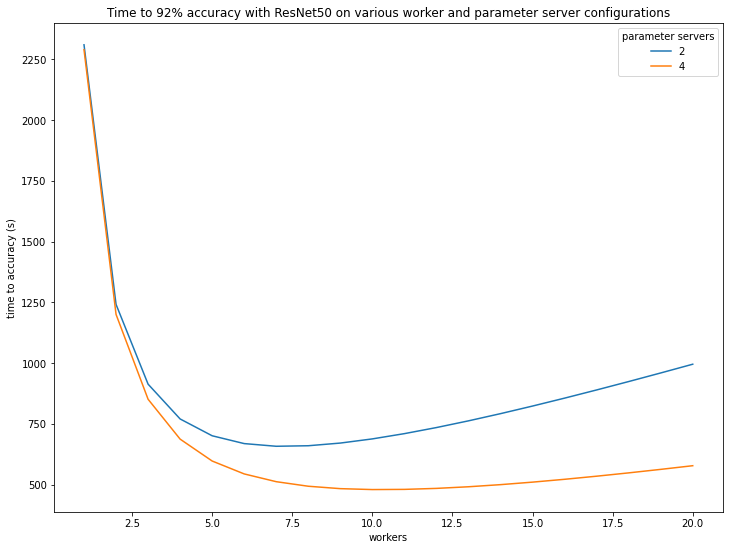

In [46]:
fig, ax = plt.subplots(figsize=(12, 9))
df['parameter servers'] = df['parameter servers'].astype('str')
sns.lineplot(x='workers', y='time to accuracy (s)', hue='parameter servers', data=df)
plt.title('Time to 92% accuracy with ResNet50 on various worker and parameter server configurations')